In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tslearn
!pip install tensorflow==1.15.0.

     |████████████████████████████████| 747kB 4.7MB/s 
     |████████████████████████████████| 412.3MB 39kB/s 
     |████████████████████████████████| 512kB 42.6MB/s 
     |████████████████████████████████| 3.8MB 39.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d25a99268dca01775ee6698ce9876e2b8b8be7370e7090a02297061c5c0e4208
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uni

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score


from keras.optimizers import Adagrad
from keras.optimizers import Adam
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Preparation

In [5]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/combined2.csv"
df = pd.read_csv(dataset_path)

df.head()
del df['Day']
del df['TimeSlot']
del df['Weekend']
del df['WorkingHour']
del df['Date']
del df['Hour']

#df.loc[df["Occupancy"] == 1, "Occupancy"] = 'Yes'
#df.loc[df["Occupancy"] == 0, "Occupancy"] = 'No'


df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


df

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,15.957720,8.711492,7.452585,5.343291,10.831549,1
2,15.993220,8.669303,7.398537,5.432407,10.799950,1
3,15.971032,8.595474,6.654588,5.481292,10.709977,1
4,16.064222,8.648209,6.606039,5.522164,10.806016,1
...,...,...,...,...,...,...
20555,7.369492,9.715227,6.051259,12.506386,8.476117,1
20556,7.517411,9.734564,5.992341,12.595342,8.548897,1
20557,7.591371,9.734564,5.992341,12.662660,8.576488,1
20558,7.591371,9.929686,5.947562,13.725319,8.756051,1


# data transformation

In [6]:
b = df.iloc[0, 0:5].values
b

array([15.90446841,  8.69883542,  7.51668876,  5.23558227, 10.79578581])

In [7]:
#creo training set
train_x = df.iloc[0,0:5].values
for i in range (1,16380):
  #aggiungo a un array la i-esima riga
  train_x = np.append(train_x, df.iloc[i, 0:5].values)
  #print (train_x.size)
  i=i+1

#print (train_x)

print ("--- shape attuale ---")
print (train_x.shape)

print ("--- modifico shape di b ---")
train_x = train_x.reshape(273,5,60)
print (train_x.shape)
#print (train_x)

--- shape attuale ---
(81900,)
--- modifico shape di b ---
(273, 5, 60)


In [8]:
#creo il test set
test_x = df.iloc[16381,0:5].values
for i in range (16382,20521):
  #aggiungo a un array la i-esima riga
  test_x = np.append(test_x, df.iloc[i, 0:5].values)
  #print (test_x.size)
  i=i+1

#print (test_x)

print ("--- shape attuale ---")
print (test_x.shape)

print ("--- modifico shape di b ---")
test_x = test_x.reshape(69,5,60)
print (test_x.shape)
#print (test_x)







#a = df.iloc[0].values
#b = np.append(a, df.iloc[1])
#print (b)
#b.reshape(1,6,2)

--- shape attuale ---
(20700,)
--- modifico shape di b ---
(69, 5, 60)


In [9]:
#creo target per training set
import statistics

train_y = 0
temp = df.iloc[0, 5]
aux = 1

for i in range (1,16380):
  temp = np.append(temp, df.iloc[i, 5])
  #print(temp)
  if((aux % 60) == 0):
    temp.tolist
    prova = statistics.mode(temp)
    #print("media dei primi %d valori target", aux)
    train_y = np.append(train_y, prova)
    #print(prova)
    temp = 0
    prova = 0
  i = i+1
  aux = aux +1 

#print(train_y)
print(train_y.size)
print(train_y.shape)


273
(273,)


In [10]:
#creo target per test set
import statistics

test_y = 0
temp = df.iloc[16381, 5]
aux = 1

for i in range (16382,20521):
  temp = np.append(temp, df.iloc[i, 5])
  #print(temp)
  if((aux % 60) == 0):
    temp.tolist
    prova = statistics.mode(temp)
    #print("media dei primi %d valori target", aux)
    test_y = np.append(test_y, prova)
    #print(prova)
    temp = 0
    prova = 0
  i = i+1
  aux = aux +1 

#print(train_y)
print(test_y.size)
print(test_y.shape)

69
(69,)


In [11]:
print (train_x.shape, train_x.size)
print (test_x.shape, test_x.size)
print (train_y.shape, train_y.size)
print (test_y.shape, test_y.size)

print("contenuti")
print(test_y)
print(train_y)

(273, 5, 60) 81900
(69, 5, 60) 20700
(273,) 273
(69,) 69
contenuti
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Multivariate Time Series Classifiers

In [12]:
!pip install pyts
!pip install tslearn

     |████████████████████████████████| 2.5MB 4.5MB/s 


In [0]:
from pyts.datasets import load_basic_motions
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
#scaler = TimeSeriesScalerMinMax()
#train_x = scaler.fit_transform(train_x)
#test_x = scaler.transform(test_x)

In [15]:
train_y.shape

(273,)

In [16]:
train_y

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

In [19]:
train_x = train_x.reshape(273, 60, 5)
test_x = test_x.reshape(69, 60, 5)

print (train_x.shape)
print (test_x.shape)

(273, 60, 5)
(69, 60, 5)


In [20]:
n_timesteps, n_outputs, n_features = train_x.shape[1], len(np.unique(train_y)), train_x.shape[2] 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)
print("N. FEATURES: ", n_features)


TIMESTEPS:  60
N. LABELS:  2
N. FEATURES:  5


In [0]:
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(train_x, train_y, test_size=0.3, stratify=train_y)

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [0]:
def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, n_features), return_sequences=True, 
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    #1
    for _ in range(2):
        model.add(LSTM(128, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(64, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    #3
    for _ in range(2):
        model.add(Dense(100, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

In [161]:
lstm2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 60, 4)             160       
_________________________________________________________________
batch_normalization_66 (Batc (None, 60, 4)             16        
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 60, 4)             0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 60, 4)             0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 60, 4)             144       
_________________________________________________________________
batch_normalization_67 (Batc (None, 60, 4)             16        
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 60, 4)           

In [0]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.002)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(train_x.shape[0]/10, batch_size))

In [217]:
history_lstm2 = lstm2.fit(X_train_cnn, y_train_cnn, epochs=40, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

Train on 191 samples, validate on 82 samples
Epoch 1/40
191/191 [==============================] - 5s 25ms/step - loss: 0.3697 - accuracy: 0.8639 - val_loss: 0.4833 - val_accuracy: 0.9268
Epoch 2/40
191/191 [==============================] - 5s 25ms/step - loss: 0.3002 - accuracy: 0.9110 - val_loss: 0.4660 - val_accuracy: 0.8537
Epoch 3/40
191/191 [==============================] - 5s 25ms/step - loss: 0.3031 - accuracy: 0.9058 - val_loss: 0.4076 - val_accuracy: 0.9024
Epoch 4/40
191/191 [==============================] - 5s 25ms/step - loss: 0.3048 - accuracy: 0.8901 - val_loss: 0.3793 - val_accuracy: 0.8902
Epoch 5/40
191/191 [==============================] - 5s 24ms/step - loss: 0.4058 - accuracy: 0.8115 - val_loss: 0.3966 - val_accuracy: 0.8415
Epoch 6/40
191/191 [==============================] - 5s 25ms/step - loss: 0.3696 - accuracy: 0.8429 - val_loss: 0.3791 - val_accuracy: 0.8902
Epoch 7/40
191/191 [==============================] - 5s 25ms/step - loss: 0.2953 - accuracy: 0.8

In [218]:
y_pred = np.argmax(lstm2.predict(test_x), axis=1)

print('Accuracy %s' % accuracy_score(test_y, y_pred))
print('F1-score %s' % f1_score(test_y, y_pred, average=None))
print(classification_report(test_y, y_pred))

Accuracy 0.7681159420289855
F1-score [0.81395349 0.69230769]
              precision    recall  f1-score   support

           0       1.00      0.69      0.81        51
           1       0.53      1.00      0.69        18

    accuracy                           0.77        69
   macro avg       0.76      0.84      0.75        69
weighted avg       0.88      0.77      0.78        69



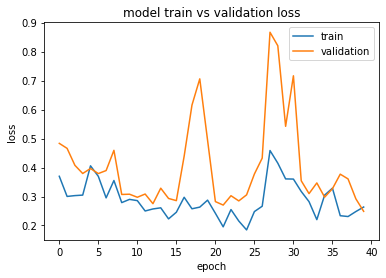

In [219]:
from matplotlib import pyplot
pyplot.plot(history_lstm2['loss'])
pyplot.plot(history_lstm2['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
X_train_cnn.shape

(218, 60, 5)

In [108]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], X_val_cnn.shape[2], 1)
X_test_cnn2 = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)

X_train_cnn2.shape

(163, 60, 5, 1)

In [0]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 3
    
    ks2_first = 4
    ks2_second = 4
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

In [111]:
cnn2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 5, 3)          30        
_________________________________________________________________
batch_normalization_49 (Batc (None, 60, 5, 3)          12        
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 60, 5, 3)          0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 60, 5, 3)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 5, 4)          196       
_________________________________________________________________
batch_normalization_50 (Batc (None, 60, 5, 4)          16        
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 60, 5, 4)         

In [0]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.02)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(train_x.shape[0]/10, batch_size))

In [116]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=40, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn2, y_val_cnn)).history

Train on 163 samples, validate on 110 samples
Epoch 1/40
163/163 [==============================] - 4s 26ms/step - loss: 0.8327 - accuracy: 0.5276 - val_loss: 0.6622 - val_accuracy: 0.7636
Epoch 2/40
163/163 [==============================] - 0s 2ms/step - loss: 0.8235 - accuracy: 0.6196 - val_loss: 0.6311 - val_accuracy: 0.7636
Epoch 3/40
163/163 [==============================] - 0s 2ms/step - loss: 0.6149 - accuracy: 0.7055 - val_loss: 0.6159 - val_accuracy: 0.7636
Epoch 4/40
163/163 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.6871 - val_loss: 0.6038 - val_accuracy: 0.7636
Epoch 5/40
163/163 [==============================] - 0s 2ms/step - loss: 0.5575 - accuracy: 0.7178 - val_loss: 0.5966 - val_accuracy: 0.7636
Epoch 6/40
163/163 [==============================] - 0s 2ms/step - loss: 0.6124 - accuracy: 0.7362 - val_loss: 0.5886 - val_accuracy: 0.7636
Epoch 7/40
163/163 [==============================] - 0s 2ms/step - loss: 0.5653 - accuracy: 0.7423 -

In [117]:
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(test_y, y_pred))
print('F1-score %s' % f1_score(test_y, y_pred, average=None))
print(classification_report(test_y, y_pred))

Accuracy 0.8260869565217391
F1-score [0.89473684 0.5       ]
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        51
           1       1.00      0.33      0.50        18

    accuracy                           0.83        69
   macro avg       0.90      0.67      0.70        69
weighted avg       0.86      0.83      0.79        69



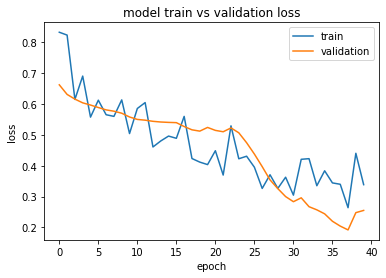

In [149]:
from matplotlib import pyplot
pyplot.plot(history_cnn2['loss'])
pyplot.plot(history_cnn2['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
def build_cnn3(n_timesteps, n_outputs, n_features):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.6))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
cnn3 = build_cnn3(n_timesteps, n_outputs, n_features)

In [152]:
cnn3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 53, 16)            656       
_________________________________________________________________
batch_normalization_63 (Batc (None, 53, 16)            64        
_________________________________________________________________
activation_4 (Activation)    (None, 53, 16)            0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 53, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 49, 32)            2592      
_________________________________________________________________
batch_normalization_64 (Batc (None, 49, 32)            128       
_________________________________________________________________
activation_5 (Activation)    (None, 49, 32)           

In [0]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0007)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(train_x.shape[0]/10, batch_size))

In [214]:
history_cnn3 = cnn3.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=mini_batch_size*2, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Train on 191 samples, validate on 82 samples
Epoch 1/100
191/191 [==============================] - 0s 848us/step - loss: 0.0560 - accuracy: 0.9895 - val_loss: 0.4354 - val_accuracy: 0.9024
Epoch 2/100
191/191 [==============================] - 0s 830us/step - loss: 0.0553 - accuracy: 0.9791 - val_loss: 0.4309 - val_accuracy: 0.9268
Epoch 3/100
191/191 [==============================] - 0s 779us/step - loss: 0.0328 - accuracy: 0.9843 - val_loss: 0.4561 - val_accuracy: 0.9268
Epoch 4/100
191/191 [==============================] - 0s 772us/step - loss: 0.0377 - accuracy: 0.9895 - val_loss: 0.4427 - val_accuracy: 0.9268
Epoch 5/100
191/191 [==============================] - 0s 841us/step - loss: 0.0485 - accuracy: 0.9791 - val_loss: 0.4191 - val_accuracy: 0.9268
Epoch 6/100
191/191 [==============================] - 0s 777us/step - loss: 0.0534 - accuracy: 0.9791 - val_loss: 0.4080 - val_accuracy: 0.9268
Epoch 7/100
191/191 [==============================] - 0s 773us/step - loss: 0.0887 -

In [215]:
y_pred = np.argmax(cnn3.predict(test_x), axis=1)

print('Accuracy %s' % accuracy_score(test_y, y_pred))
print('F1-score %s' % f1_score(test_y, y_pred, average=None))
print(classification_report(test_y, y_pred))

Accuracy 0.855072463768116
F1-score [0.89795918 0.75      ]
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        51
           1       0.68      0.83      0.75        18

    accuracy                           0.86        69
   macro avg       0.81      0.85      0.82        69
weighted avg       0.87      0.86      0.86        69



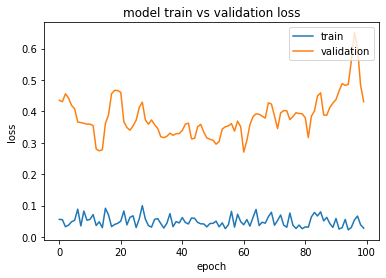

In [216]:
from matplotlib import pyplot
pyplot.plot(history_cnn3['loss'])
pyplot.plot(history_cnn3['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()